# CSI6900 Project - Designing Amino Acid Sequences for Target Protein Structures Using Deep Learning

Supervisor: Dr. Herna Viktor, Dr. Eric Paquet

Student: Tiancheng Qin

Term: Winter 2025

The goal of this project is to develop a system that generates amino acid sequences for specific 3D protein structures.

This project implement four different models to achieve the objective.
- `Multi-Scale DistanceTransformer` (Multi-scale CNN + residual + Transformer)
- `SequenceAutoencoder + Heteroencoder` (Sequence CNN-Autoencoder + CNN-Heteroencoder)
- `ProteinCNNLSTM` (CNN + LSTM)

The computing device using a Nvidia Geforce RTX 4070 12 GB GPU, AMD Ryzen 9 3900X CPU, and 32 GB DDR4 RAM.


## Dependency Library 

In [1]:
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split

## Global Setting
Setting Random seed, Warning filter, torch device, and torch print option.

In [2]:
# Global settings
RANDOM_SEED = 2025
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

warnings.filterwarnings("ignore", message="Workbook contains no default style")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_printoptions(precision=4, sci_mode=False)
print(f"Current Device: {device}")


Current Device: cuda


## Data Preprocessing Helper Function
The following code defines the helper functions needed to preprocessing data and construct the dataset.

For data preprocessing:
- `read_aa_csv(file_path)`: read protein dataset from csv file at "file_path"
- `read_coordinates_excel(alpha_c_dir, pdb_id, chain_id)`: read coordinates from excel files with "{pdb_id}_{chain_id}.xlsx" files in "alpha_c_dir"
- `plot_sequence_length_distribution(df, column_name="Sequence_Length", bins=10)`: plotting the distribution of the sequence length in the dataset to decide the "max_len"
- `check_file_exist(df, alpha_c_path)`: if there is not a possible excel file for the providing protein, we will delete it from the dataset.
- `remove_unknown(df)`: remove the protein contain unknown amino acid ("X") or rare amino acid ("U")
- `remove_duplicate_sequences(df)`: remove the duplicate sequences that may cause the data leakage during the split of train and test set.
- `filter_unique_pdb(df)`: (optional) for some proteins with the same pdb_id but different chain_id, they may bring a lot of very similar amino acid sequences, which will imbalance the data, so we try to sample only one chain for each protein.

For dataset construction:
- `normalize_distance_matrix(dist_mat)`: min-max normalize the distance matrix
- `compute_distance_matrix(coords, L=64)`: firstly compute distance matrix based on origin sequence length, then normalise and intercept the first 64 $\times$ 64 matrix. 
- `get_unique_amino_acids(sequences)`: Counting all occurrences of amino acid species
- `create_amino_acid_mapping(unique_aas)`: create a mapping from amino acid sequence to the index.
- `one_hot_encode_sequence(seq, max_len, aa_to_idx, num_aa)`: one hot encoding the sequence to 64 $\times$ 20 matrix, where 1 means it  belong to the type of its column, and 0 means not belong to that column. 
- `generate_random_symmetric_matrix(num_aa)`: (Optional) Generate a random symmetric matrix to transform origin one hot into an inverse-possible random matrix that reduce the occurrence of "0" in the matrix


In [3]:
def read_aa_csv(file_path):
    # Read CSV with columns: PDB_ID, Chain_ID, Amino_Acid_Sequence
    df = pd.read_csv(file_path, names=["PDB_ID", "Chain_ID", "Amino_Acid_Sequence"])
    return df

def read_coordinates_excel(alpha_c_dir, pdb_id, chain_id):
    # Read Excel file of coordinates for the given pdb_id and chain_id
    file_path = Path(f"{alpha_c_dir}/{pdb_id}_{chain_id}.xlsx")
    if not file_path.exists():
        return np.array([])
    df = pd.read_excel(file_path, header=None)
    coords = df.to_numpy(dtype=float)
    return coords

def plot_sequence_length_distribution(df, column_name="Sequence_Length", bins=10):
    # Plot histogram of sequence lengths using defined bins
    bin_edges = range(0, 1024, bins)
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(df[column_name], bins=bin_edges, edgecolor='black')
    plt.xticks(bins)
    plt.title("Distribution of Amino Acid Sequence Length")
    plt.xlabel("Sequence Length")
    plt.ylabel("Count")
    plt.grid(axis="y", alpha=0.75)
    plt.show()

def check_file_exist(df, alpha_c_path):
    # Filter rows where the coordinate file exists
    keep_flags = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        pdb_id = row["PDB_ID"]
        chain_id = str(row["Chain_ID"])
        file_path = Path(f"{alpha_c_path}/{pdb_id}_{chain_id}.xlsx")
        keep_flags.append(file_path.exists())
    df_filtered = df[keep_flags].copy()
    print(f"Removed {len(df) - len(df_filtered)} rows due to missing coordinate files.")
    return df_filtered

def remove_unknown(df):
    # Remove rows with unknown or rare amino acids (X or U)
    original_count = len(df)
    df_filtered = df[~df["Amino_Acid_Sequence"].str.contains("X|U")].copy()
    print(f"Removed {original_count - len(df_filtered)} rows with unknown amino acids.")
    return df_filtered

def remove_duplicate_sequences(df):
    # Remove duplicate sequences based on Amino_Acid_Sequence
    original_count = len(df)
    df_unique = df.drop_duplicates(subset=["Amino_Acid_Sequence"])
    print(f"Removed {original_count - len(df_unique)} duplicate sequences.")
    return df_unique

def filter_unique_pdb(df):
    # Keep one random row per unique PDB_ID
    filtered_df = df.groupby("PDB_ID", group_keys=False).sample(n=1)
    print(f"Filtered to {len(filtered_df)} unique PDB IDs.")
    return filtered_df

In [4]:
def normalize_distance_matrix(dist_mat):
    # Normalize the distance matrix by its maximum value
    max_val = dist_mat.max()
    if max_val > 1e-8:
        dist_mat = dist_mat / max_val
    return dist_mat

def compute_distance_matrix(coords, L=64):
    coords = np.array(coords, dtype=np.float32)
    n = len(coords)
    if n == 0:
        return np.zeros((L, L), dtype=np.float32)
    full_dist_mat = np.zeros((n, n), dtype=np.float32)
    # Compute the distance matrix from coordinates
    for i in range(n):
        for j in range(n):
            full_dist_mat[i, j] = 0.0 if i == j else np.linalg.norm(coords[i] - coords[j])
            
    # normalise the distance matrix
    full_dist_mat = normalize_distance_matrix(full_dist_mat)
    if n >= L:
        # intercept first L sequence from origin sequences
        dist_mat = full_dist_mat[:L, :L]
    else:
        # padding 0 for sequence < L which should never be reached
        dist_mat = np.zeros((L, L), dtype=np.float32)
        dist_mat[:n, :n] = full_dist_mat
    return dist_mat

def get_unique_amino_acids(sequences):
    # Get a set of unique amino acids from the list of sequences
    unique_aas = set()
    for seq in sequences:
        unique_aas.update(seq)
    return unique_aas

def create_amino_acid_mapping(unique_aas):
    # Create a mapping from amino acid to index
    sorted_aas = sorted(list(unique_aas))
    aa_to_idx = {aa: i for i, aa in enumerate(sorted_aas)}
    return aa_to_idx

def one_hot_encode_sequence(seq, max_len, aa_to_idx, num_aa):
    # Convert sequence to one-hot encoding of fixed length max_len
    arr = np.zeros((max_len, num_aa), dtype=np.float32)
    for i, aa in enumerate(seq):
        if i >= max_len:
            break
        idx = aa_to_idx.get(aa, -1)
        if idx >= 0:
            arr[i, idx] = 1.0
    return arr

def generate_random_symmetric_matrix(num_aa):
    # Generate a random symmetric matrix of shape (num_aa, num_aa)
    random_matrix = torch.rand(num_aa, num_aa)
    transform_matrix = (random_matrix + random_matrix.t()) / 2
    return transform_matrix

## Dataset Class
This class defines a custom PyTorch `Dataset` for processing protein data. It takes a pandas DataFrame containing protein metadata and performs the following operations :

- **Coordinate Reading:** Uses a helper function `read_coordinates_excel` to read protein coordinates from an Excel file.
- **Distance Matrix Computation:** Calls `compute_distance_matrix` to compute a normalized distance matrix from the coordinates.
- **Sequence Encoding:** Converts the amino acid sequence into a one-hot encoded array using `one_hot_encode_sequence`.
- **Record Storage:** Stores the processed sequence and distance matrix in a list of records.

When an item is retrieved via the `__getitem__` method, it returns a dictionary containing:
- `dist_input`: A tensor of the distance matrix with shape `(1, max_len, max_len)`.
- `seq_input`: A tensor of the one-hot encoded sequence with shape `(1, max_len, num_aa)`. If a transformation matrix is provided, it is applied to the sequence input.
- `seq_target`: A tensor of target class indices (obtained via `argmax` on the one-hot encoded sequence) with shape `(max_len,)`.
- Additional metadata (`pdb_id` and `chain_id`).



In [5]:

class ProteinDataset(Dataset):
    def __init__(self, df, alpha_c_dir, aa_to_idx, num_aa, max_len=64, transform_matrix=None):
        super().__init__()
        self.records = []
        self.aa_to_idx = aa_to_idx
        self.num_aa = num_aa
        self.max_len = max_len
        self.alpha_c_dir = alpha_c_dir
        self.transform_matrix = transform_matrix
        
        # Iterate through each row in the DataFrame to build the dataset
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Building Dataset"):
            pdb_id = row["PDB_ID"]
            chain_id = str(row["Chain_ID"])
            seq = row["Amino_Acid_Sequence"]
            # Read protein coordinates from the Excel file
            coords = read_coordinates_excel(alpha_c_dir, pdb_id, chain_id)
            if len(coords) == 0:
                continue
            # Compute the distance matrix with a fixed maximum length
            dist_mat = compute_distance_matrix(coords, L=max_len)
            # One-hot encode the amino acid sequence
            one_hot_seq = one_hot_encode_sequence(seq, max_len, aa_to_idx, num_aa)
            # Append the processed record to the list
            self.records.append({
                "pdb_id": pdb_id,
                "chain_id": chain_id,
                "seq_arr": one_hot_seq,   
                "dist_arr": dist_mat      
            })

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        item = self.records[idx]
        # Convert the distance matrix to a tensor with shape (1, max_len, max_len)
        dist_input = torch.from_numpy(item["dist_arr"]).unsqueeze(0).float().to(device)
        # Convert the one-hot encoded sequence to a tensor with shape (1, max_len, num_aa)
        seq_input = torch.from_numpy(item["seq_arr"]).unsqueeze(0).float().to(device)
        # Create target tensor by taking the argmax across the one-hot dimension (shape: max_len)
        seq_target = torch.from_numpy(np.argmax(item["seq_arr"], axis=1)).long().to(device)
        # If a transformation matrix is provided, apply it to the sequence input
        if self.transform_matrix is not None:
            seq_input = torch.matmul(seq_input, self.transform_matrix)
        # Return a dictionary containing the inputs and metadata
        return {
            "dist_input": dist_input,
            "seq_input": seq_input,
            "seq_target": seq_target,
            "pdb_id": item["pdb_id"],
            "chain_id": item["chain_id"]
        }


## Read, Analysis and Preprocessing Data
Performs Read, Analysis and Preprocessing Data in the following steps:
- Loading and Preprocessing: Loads the CSV data containing protein sequences, computes the sequence lengths, and plots the distribution of these lengths.

- Filtering: Filters the DataFrame to keep sequences with a length between 64 and 128, removes rows with missing coordinate files, unknown amino acids, and duplicate sequences.

- Mapping and Sampling: Extracts the unique amino acids and builds a mapping from amino acid to index. It then randomly samples 50,000 records for building the dataset.

- Dataset Construction and Splitting:Constructs a `ProteinDataset` using the filtered data and splits it into training, validation, and test sets.



In [6]:
# Define paths and parameters
csv_path = "dataset/large/AA.csv"           # CSV file path containing protein sequences
alpha_c_dir = "dataset/large/PDBalphaC"     # Directory with protein coordinate Excel files
max_len = 64                                # Maximum sequence length

print("Loading CSV data...")
df = read_aa_csv(csv_path)
# Compute sequence lengths
df["Sequence_Length"] = df["Amino_Acid_Sequence"].apply(len)

Loading CSV data...


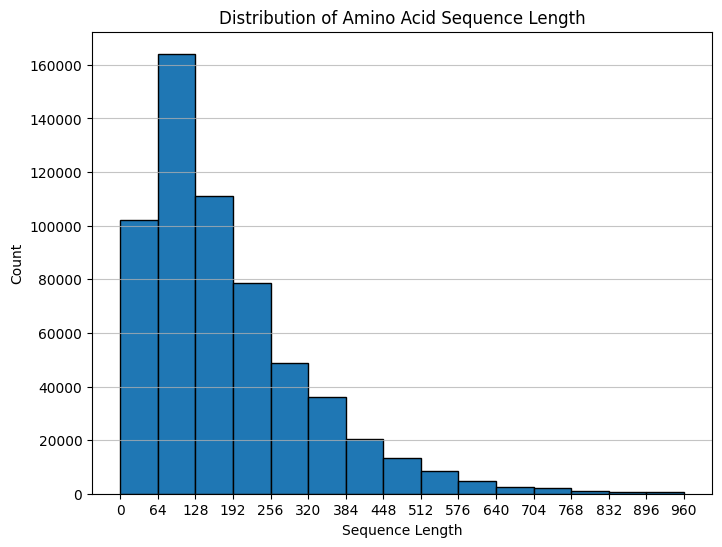

In [7]:
# Plot the distribution of sequence lengths
plot_sequence_length_distribution(df, column_name="Sequence_Length", bins=64)


In [8]:
# Filter DataFrame based on sequence length
df_filtered = df[(df["Sequence_Length"] >= max_len) & (df["Sequence_Length"] <= max_len * 2)].copy()
# Remove rows without coordinate files
df_filtered = check_file_exist(df_filtered, alpha_c_dir)
# Remove rows with unknown and rare amino acids (e.g., 'X' or 'U')
df_filtered = remove_unknown(df_filtered)
# Optionally, filter for unique PDB IDs
df_filtered = filter_unique_pdb(df_filtered)
# Remove duplicate sequences
df_filtered = remove_duplicate_sequences(df_filtered)
# Randomly sample 50,000 records
# df_filtered = df_filtered.sample(50000, random_state=RANDOM_SEED)

# Build amino acid mapping
all_seqs = df_filtered["Amino_Acid_Sequence"].tolist()
unique_aas = get_unique_amino_acids(all_seqs)
aa_to_idx = create_amino_acid_mapping(unique_aas)
idx_to_aa = {v: k for k, v in aa_to_idx.items()}
num_aa = len(aa_to_idx)
print("Number of distinct amino acids:", num_aa)

100%|██████████| 165981/165981 [00:25<00:00, 6632.50it/s]


Removed 3274 rows due to missing coordinate files.
Removed 12605 rows with unknown amino acids.
Filtered to 63811 unique PDB IDs.
Removed 21638 duplicate sequences.
Number of distinct amino acids: 20


In [9]:
# Optionally define a transformation matrix (set to None by default)
transform_matrix = generate_random_symmetric_matrix(num_aa).to(device)  # or use: None

# Building data sets using the filtered DataFrame
dataset = ProteinDataset(
    df_filtered, 
    alpha_c_dir, 
    aa_to_idx, 
    num_aa, 
    max_len=max_len, 
    transform_matrix=transform_matrix
)

print("Dataset size:", len(dataset))

Building Dataset: 100%|██████████| 42173/42173 [39:32<00:00, 17.78it/s]

Dataset size: 42173


In [10]:
# Split the dataset into training, validation, and test sets (80%:10%:10%)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size],
                                            generator=torch.Generator().manual_seed(RANDOM_SEED))
print(f"Train: {len(train_set)}, Validation: {len(val_set)}, Test: {len(test_set)}")


Train: 33738, Validation: 4217, Test: 4218


## Functions for Model Evaluation

This code defines four functions:
- `smith_waterman(seq1, seq2, match=1, mismatch=-1, gap=-1)`: Computes the Smith-Waterman local alignment score and aligned sequences between two sequences. Adapted from Slavianap's Github [1].
- `evaluate_model_sw(model, loader, idx_to_aa)`: Evaluates a model by computing Smith-Waterman scores on a data loader.
- `plot_learning_curve(train_losses, val_losses, model_name="Model")`: Plots the training and validation loss curves.
- `clear_gpu_memory`: Clears the GPU memory to free up resources.

In [11]:
def smith_waterman(seq1, seq2, match=1, mismatch=-1, gap=-1):
    """
    smith_waterman code adapted from slavianap's Github: https://github.com/slavianap/Smith-Waterman-Algorithm/blob/master/Script.py
    """
    # initialize score and tracing matrices
    m, n = len(seq1), len(seq2)
    score_matrix = np.zeros((m+1, n+1))
    tracing_matrix = np.zeros((m+1, n+1), dtype=int)
    max_score = -1
    max_pos = (0, 0)
    
    # fill matrices
    for i in range(1, m+1):
        for j in range(1, n+1):
            s = match if seq1[i-1] == seq2[j-1] else mismatch
            diag = score_matrix[i-1, j-1] + s
            up = score_matrix[i-1, j] + gap
            left = score_matrix[i, j-1] + gap
            best = max(0, diag, up, left)
            score_matrix[i, j] = best
            if best == 0:
                tracing_matrix[i, j] = 0
            elif best == diag:
                tracing_matrix[i, j] = 1
            elif best == up:
                tracing_matrix[i, j] = 2
            else:
                tracing_matrix[i, j] = 3
            if best >= max_score:
                max_score = best
                max_pos = (i, j)
                
    # traceback to build aligned sequences
    aligned_seq1 = ""
    aligned_seq2 = ""
    i, j = max_pos
    while score_matrix[i, j] > 0:
        if tracing_matrix[i, j] == 1:
            aligned_seq1 = seq1[i-1] + aligned_seq1
            aligned_seq2 = seq2[j-1] + aligned_seq2
            i -= 1
            j -= 1
        elif tracing_matrix[i, j] == 2:
            aligned_seq1 = seq1[i-1] + aligned_seq1
            aligned_seq2 = '-' + aligned_seq2
            i -= 1
        else:
            aligned_seq1 = '-' + aligned_seq1
            aligned_seq2 = seq2[j-1] + aligned_seq2
            j -= 1
    return score_matrix, max_score, aligned_seq1, aligned_seq2

def evaluate_model_sw(model, loader, idx_to_aa, samples=10):
    model.eval()
    sw_scores = []
    examples = []
    with torch.no_grad():
        for batch in loader:
            dist_input = batch["dist_input"].to(device)
            seq_target = batch["seq_target"].to(device)
            # get output from model
            logits = model(dist_input)
            # check if contains some other output like mu, var from VAE
            if isinstance(logits, tuple):
                logits = logits[0]
            # argmax logit into indices
            pred_indices = torch.argmax(logits, dim=-1)
            batch_size = pred_indices.size(0)
            for i in range(batch_size):
                # transform indices into sequence and apply smith-waterman algorithm
                pred_seq = "".join([idx_to_aa[int(idx)] for idx in pred_indices[i].cpu().numpy()])
                true_seq = "".join([idx_to_aa[int(idx)] for idx in seq_target[i].cpu().numpy()])
                _, score, aligned_pred, aligned_true = smith_waterman(pred_seq, true_seq)
                sw_scores.append(score)
                # append first 10 as the examples
                if len(examples) < samples:
                    examples.append({
                        "pred_seq": pred_seq,
                        "true_seq": true_seq,
                        "aligned_pred": aligned_pred,
                        "aligned_true": aligned_true,
                        "sw_score": score
                    })
    avg_sw = np.mean(sw_scores)
    return avg_sw, sw_scores, examples

def evaluate_duel_model_sw(seq_model,hetero_model, loader, idx_to_aa, samples=10, transform_matrix=None):
    seq_model.eval()
    hetero_model.eval()
    sw_scores = []
    examples = []
    
    with torch.no_grad():
        for batch in loader:
            dist_input = batch["dist_input"].to(device)
            seq_input = batch["seq_input"].to(device)
            seq_target = batch["seq_target"].to(device)
            # get output from model
            z_het = hetero_model(dist_input)
            _, z_gt = seq_model(seq_input)
            
            
            
            batch_size = seq_input.size(0)
            z_het = seq_model.fc_dec(z_het)
            z_gt = seq_model.fc_dec(z_gt)
            z_het = z_het.view(batch_size,128, 8, 3)
            z_gt = z_gt.view(batch_size,128, 8, 3)
            recon_seq = seq_model.decoder(z_het)
            recon_gt = seq_model.decoder(z_gt)
            if transform_matrix is not None:
                transform_matrix_inverse = torch.pinverse(transform_matrix).to(device)
                recon_seq = torch.matmul(recon_seq.squeeze(1),transform_matrix_inverse)
                recon_gt = torch.matmul(recon_gt.squeeze(1),transform_matrix_inverse)
            # argmax logit into indices
            pred_indices = torch.argmax(recon_seq, dim=-1)
            gt_indices = torch.argmax(recon_gt, dim=-1)
            
            
            for i in range(batch_size):
                # transform indices into sequence and apply smith-waterman algorithm
                pred_seq = "".join([idx_to_aa[int(idx)] for idx in pred_indices[i].cpu().numpy()])
                true_seq = "".join([idx_to_aa[int(idx)] for idx in seq_target[i].cpu().numpy()])
                _, score, aligned_pred, aligned_true = smith_waterman(pred_seq, true_seq)
                sw_scores.append(score)
                # append first 10 as the examples
                if len(examples) < samples:
                    examples.append({
                        "pred_seq": pred_seq,
                        "true_seq": true_seq,
                        "aligned_pred": aligned_pred,
                        "aligned_true": aligned_true,
                        "sw_score": score
                    })
    avg_sw = np.mean(sw_scores)
    return avg_sw, sw_scores, examples

def plot_learning_curve(train_losses, val_losses, model_name="Model"):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss",linestyle='-')
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss",linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig("./images/"+model_name + ".pdf", format="pdf", bbox_inches="tight")
    plt.show()

def plot_sw_distribution(smith_scores,model_name="model"):
    print(f"Collected {len(smith_scores)} Smith-Waterman scores.")
    plt.figure(figsize=(8,6))
    plt.hist(smith_scores, bins=20, edgecolor='black')
    plt.xlabel("SW Score")
    plt.ylabel("Frequency")
    plt.title(f"{model_name} Smith-Waterman Score Distribution on Test Set")
    plt.savefig("./images/"+model_name + "_sw.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def clear_gpu_memory():
    import gc
    gc.collect()
    torch.cuda.empty_cache()


## Shared Network Structure
This code defines two helper modules used in neural network models.

- `ResidualBlock2d`: Implements a 2D residual block with two convolution layers. It applies batch normalization, LeakyReLU activation, and dropout. If the input and output channels differ, a 1×1 convolution is applied to the shortcut. Code adapted from 
Chen-Yu Chang's blog [2].

- `PositionalEncoding`: Adds sinusoidal positional encoding to input sequences and applies dropout. Code adapted from Yakov Dan's answer [3].



In [12]:
class ResidualBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout_rate=0.3):
        super(ResidualBlock2d, self).__init__()
        # Main convolutional path
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample  = None
        # Shortcut path if channels differ
        if in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        identity = x
        out = self.conv(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=64,dropout=0.2):
        super(PositionalEncoding, self).__init__()
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Add positional encoding
        x = x + self.pe[:, :x.size(1)]
        return x

## Model 1 - MultiScaleConvTransformer Model and Training

**Model Design:**  
- **Input:** distance matrix tensor of shape `(B, 1, max_len, max_len)`.  
- **Architecture:**  
    - **Encoder:**
      - Multi-scale convolution branches (kernel sizes 3, 5, and 7).   
      - A projection layer to a latent space (`conv_proj`).  
      - Two convolution blocks with a residual connection (using a 1×1 conv on the shortcut). 
      - Adaptive average pooling to reduce spatial dimensions. 
    - **Decoder:** 
      - A positional encoding module followed by a Transformer encoder.  
      - A fully connected layer outputs logits over amino acid classes.  
- **Output:** Sequence types logits tensor of shape `(B, max_len, num_aa)`.

MultiScaleConvTransformer use a multi-scale convolution and residual connection to extract features from the distance matrix, and use transformer encoder to encoder the latent dimension, and finally a fully connected layer to generate the probability of predicting types of amino acid in that position.

![Model 1](./images/MultiScaleConvTransformer.png)

In [25]:
class MultiScaleConvTransformer(nn.Module):
    def __init__(self, max_len, num_aa,latent_dim=128,d_model=256, dropout_rate=0.2):
        super(MultiScaleConvTransformer, self).__init__()
        # multi-scale convolution branches
        self.branch3 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.branch5 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.branch7 = nn.Conv2d(1, 32, kernel_size=7, padding=3)
        
        # batchNorm, activation, dropout block
        self.ms_seq = nn.Sequential(
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate)
        )
        # project to latent space
        self.conv_proj = nn.Conv2d(96, latent_dim, kernel_size=1)
        
        # first convolution block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(latent_dim, d_model, kernel_size=3, padding=1),
            nn.BatchNorm2d(d_model),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate)
        )
        
        # residual connection
        self.residual1 = nn.Conv2d(latent_dim, d_model, kernel_size=1)
        
        # second convolution block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
            nn.BatchNorm2d(d_model),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate)
        )
    
        # adaptive pooling to (max_len, 1)
        self.pool = nn.AdaptiveAvgPool2d((max_len, 1))
    
        # Positional encoding and transformer encoder
        self.pos_enc = PositionalEncoding(d_model, max_len, dropout=dropout_rate)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout_rate, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.dropout_transformer = nn.Dropout(dropout_rate)
        
        # Final classification layer
        self.fc = nn.Linear(d_model, num_aa)

    def forward(self, dist_input):
        # compute multi-scale features
        b3 = self.branch3(dist_input)
        b5 = self.branch5(dist_input)
        b7 = self.branch7(dist_input)
        
        # concat multi-scale features
        x = torch.cat([b3, b5, b7], dim=1)  
        x = self.ms_seq(x)
        
        # project features
        x = self.conv_proj(x)               
        
        # convolution block with residual connection
        x_block = self.conv_block1(x)  
        res = self.residual1(x)        
        x = x_block + res
        x = self.conv_block2(x) 
        
        # pooling and reshape for transformer input
        x = self.pool(x)                    
        x = x.squeeze(-1)                   
        x = x.permute(0, 2, 1)             
        
        # add positional encoding and pass through transformer
        x = self.pos_enc(x)
        x = self.transformer_encoder(x)
        x = self.dropout_transformer(x)
        
        # classification layer
        logits = self.fc(x)                 
        return logits


**Training and Evaluation:**  
- Uses cross-entropy loss with label smoothing.  
- Uses an AdamW optimizer and a cosine annealing warm restart scheduler.  
- Early stopping is applied based on the validation loss.
- After training, the model is evaluated using the Smith-Waterman algorithm, and the learning curve is plotted.
- Finally, GPU memory is cleared for the next model training.

In [22]:

def train_distance_transformer(model, train_loader, val_loader, num_epochs=1000, lr=1e-3, weight_decay=1e-4, patience=300):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2, eta_min=1e-6)

    best_val_loss = float("inf")
    early_stop_counter = 0
    best_model_state = None
    train_losses = []
    val_losses = []
    

    for epoch in range(1, num_epochs+1):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            dist_input = batch["dist_input"]
            seq_target = batch["seq_target"]
            
            logits = model(dist_input)
            
            loss = criterion(logits.view(-1, logits.size(-1)), seq_target.view(-1))
            if torch.isnan(loss):
                print("NaN loss detected, skipping batch.")
                continue
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * dist_input.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                dist_input = batch["dist_input"]
                seq_target = batch["seq_target"]
                logits = model(dist_input)
                loss = criterion(logits.view(-1, logits.size(-1)), seq_target.view(-1))
                val_loss += loss.item() * dist_input.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        scheduler.step()
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch {epoch}: LR = {current_lr:.2e}, Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
            
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            best_model_state = model.state_dict()
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            },'best_model_disttransformer.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"Model 1 Training complete. Best Val Loss: {best_val_loss:.6f}")
    return model, train_losses, val_losses


In [23]:
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# Initialize and train the model
model1 = MultiScaleConvTransformer(max_len=max_len, num_aa=num_aa, latent_dim=256,d_model=256, dropout_rate=0.2).to(device)
print(model1)


model1, m1_train_losses, m1_val_losses = train_distance_transformer(
    model1,
    train_loader,
    val_loader,
    num_epochs=50000,
    lr=1e-3,
    patience=1600,
    weight_decay=1e-4,
)

MultiScaleDistanceTransformer(
  (branch3): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (branch5): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (branch7): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (ms_seq): Sequential(
    (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
  )
  (conv_proj): Conv2d(96, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv_block1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (residual1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv_block2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [32]:
# Evaluate using Smith-Waterman score
avg_sw1, sw_scores1, sw_examples1 = evaluate_model_sw(model1, test_loader, idx_to_aa)
print(f"Model 1 Average SW Score: {avg_sw1:.4f}")
for ex in sw_examples1:
    print(ex)

Model 1 Average SW Score: 23.1107
{'pred_seq': 'IVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSG', 'true_seq': 'IVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSG', 'aligned_pred': 'IVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSG', 'aligned_true': 'IVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSG', 'sw_score': np.float64(64.0)}
{'pred_seq': 'GIDGSPGKYKIKGGTLYKVLKPVVGEKAKKGDVVSFHYTGTLENGTVFDSFNEGEPVTFKLGSE', 'true_seq': 'GAMAKPKTKLLEGGIIIEDRVTGKGPHAKKGTRVGMRYVGKLKNGKVFDKNTKGKPFVFKLGQG', 'aligned_pred': 'NGTVFDSFN-EGEP-VTFKLG', 'aligned_true': 'NGKVFD-KNTKGKPFV-FKLG', 'sw_score': np.float64(5.0)}
{'pred_seq': 'KTFKGLAEAIIDALNEKDLEERAKAGLSYVVIGIDGPEALGITSFEEALELLEELGYRVDPDIP', 'true_seq': 'ELFANPRNAAAGSLRQLDPKVAASRQLDLFVYGLADAEALGIASHSEALDYLQALGFKVNPERR', 'aligned_pred': 'EALGITSFEEAL', 'aligned_true': 'EALGIASHSEAL', 'sw_score': np.float64(6.0)}
{'pred_seq': 'GDSEPLLAFIEAILALPYTAPVPGPIVVHCSAGIGRTTAFVVFFVALEQLAAHGEVDLEGIVAA', 

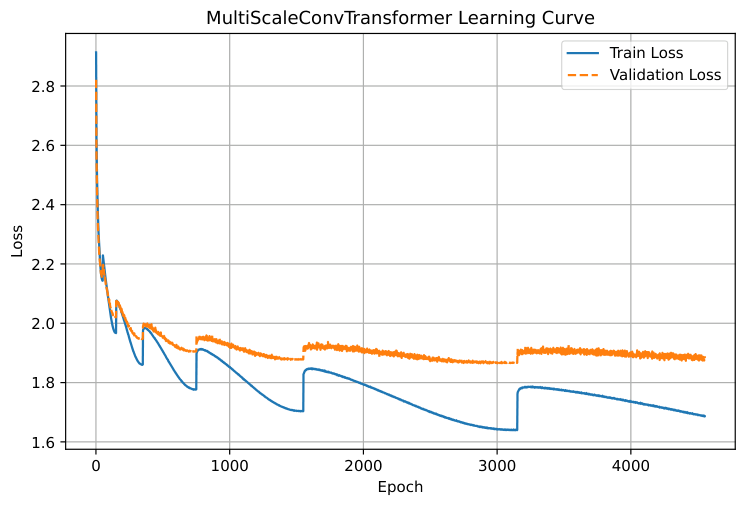

In [38]:
plot_learning_curve(m1_train_losses, m1_val_losses, model_name="MultiScaleConvTransformer")

Collected 4218 Smith-Waterman scores.


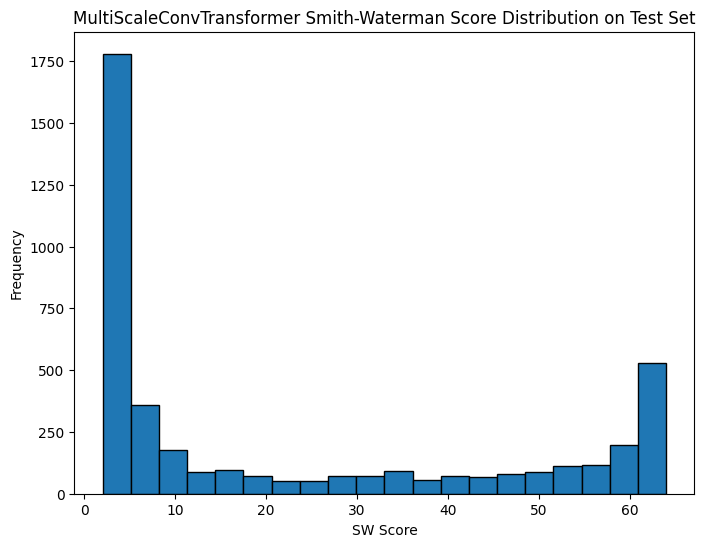

In [34]:
plot_sw_distribution(sw_scores1,model_name="MultiScaleConvTransformer")

## Model 2 - Two Model: SequenceAutoencoder and HeteroEncoder

This method contains two type of VAE and train them together.

- **SequenceAutoencoder**  
    - **Input:** Sequence one hot tensor of shape `(B, 1, max_len, num_aa)`.
    - **Architecture:**  
        - **Encoder:**
            - Uses several 2D residual blocks (with max pooling) to encode a one-hot encoded protein sequence.  
            - Flattens the features and passes them through fully connected layers to compute latent representation
        - **Decoder:** 
            - The decoder reconstructs the input using a fully connected layer followed by transposed convolution layers.
    - **Output:** Reconstructed sequence, latent vector `latent`.

- **HeteroEncoder**  
    - **Input:** Distance matrix tensor of shape `(B, 1, max_len, max_len)`.  
    - **Architecture:**  
        - **Encoder:**
            - Uses similar residual blocks and max pooling to encode a distance matrix. 
        - **Project Network:** 
            - Uses a shared fully connected network to compute latent variables.
    - **Output:** Latent vector `latent`.

SequenceAutoencoder try to generate latent features from amino acid Sequence. HeteroEncoder try to map the latent feature from Distance matrix with the latent feature from CNNSequenceVAE. However, I found it difficult to decrease the Cosine Similarity Loss between two latent. For more detail about this problem please see the Markdown section `Problems and challenges encountered in the project --- Train Two Models Simultaneously` at the bottom of this notebook.

![Model 2](./images/dual_model.png)



In [ ]:
class SequenceAutoencoder(nn.Module):

    def __init__(self, latent_dim=256,dropout_rate = 0.2):
        super(SequenceAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            ResidualBlock2d(1, 32, dropout_rate=dropout_rate),
            nn.MaxPool2d(2),
            ResidualBlock2d(32, 64, dropout_rate=dropout_rate),
            nn.MaxPool2d(2),
            ResidualBlock2d(64, 128, dropout_rate=dropout_rate),
            nn.MaxPool2d(2)
        )


        self.fc_enc = nn.Linear(128 * 8 * 2, latent_dim)

        self.latent_norm = nn.LayerNorm(latent_dim)

        self.fc_dec = nn.Linear(latent_dim, 128 * 8 * 3)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1,0)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
            # use a sigmoid to output a number between 0, 1
            nn.Sigmoid()
        )
        self.tanh = nn.Tanh()
    def forward(self, x):

        enc = self.encoder(x)

        B = x.size(0)
        enc_flat = enc.view(B, -1)
        latent = self.fc_enc(enc_flat)
        latent = self.latent_norm(latent)

        dec_input = self.fc_dec(latent)
        dec_input = dec_input.view(B, 128, 8, 3)
        x_recon = self.decoder(dec_input) 
        return x_recon, latent

In [18]:

class Heteroencoder(nn.Module):
    def __init__(self, latent_dim=256,dropout_rate=0.2):
        super(Heteroencoder, self).__init__()
        self.encoder = nn.Sequential(
            ResidualBlock2d(1, 32, dropout_rate=dropout_rate),
            nn.MaxPool2d(2),
            ResidualBlock2d(32, 64, dropout_rate=dropout_rate),
            nn.MaxPool2d(2),
            ResidualBlock2d(64, 128, dropout_rate=dropout_rate),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(512, latent_dim)
        )
        self.latent_norm = nn.LayerNorm(latent_dim)
        self.tanh = nn.Tanh()
    def forward(self, x):

        feat = self.encoder(x)
        B = x.size(0)
        feat_flat = feat.view(B, -1)
        latent= self.fc_layers(feat_flat)

        latent = self.latent_norm(latent)
        return latent

**Training and Evaluation:**:
- Trains both models at same time.  
- Minimizes reconstruction loss (MSE) for CNNSequenceVAE, mapping loss between the latent vectors, and KL divergence losses.  
- Uses an AdamW optimizer with a ReduceLROnPlateau scheduler.
- Early stopping is applied based on the validation loss.
- Finally, GPU memory is cleared for the next model training.

In [14]:
def cosine_similarity_loss(z1, z2):
    cos_sim = F.cosine_similarity(z1, z2, dim=1)
    return 1 - cos_sim.mean()

def train_SequenceAutoencoder_and_heteroencoder(seq_ae, heteroencoder, train_loader, val_loader, num_epochs=100, lr=1e-3, weight_decay=1e-5,lambda_mapping=1.0,patience=10):
    criterion = nn.MSELoss()
    optimizer = AdamW(list(seq_ae.parameters()) + list(heteroencoder.parameters()), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=20)
    best_val_loss = float('inf')
    early_stop_counter = 0
    best_state_seq = None
    best_state_het = None
    train_losses = []
    val_losses = []
    annel_epoch = 5000
    for epoch in range(1, num_epochs+1):
        seq_ae.train()
        heteroencoder.train()
        total_train_loss = 0.0
        
        for batch in train_loader:
            optimizer.zero_grad()
            seq_input = batch['seq_input']   
            dist_input = batch['dist_input']

            recon_seq, latent_seq = seq_ae(seq_input)
            loss_ae = criterion(recon_seq, seq_input)
            
            latent_het = heteroencoder(dist_input)
            loss_mapping = cosine_similarity_loss(latent_het, latent_seq) 
            
            lambda_mapping_current = lambda_mapping * min(1,epoch/annel_epoch)
            total_loss = loss_ae + lambda_mapping_current * loss_mapping

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(seq_ae.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(heteroencoder.parameters(), 1.0)
            optimizer.step()

            total_train_loss += total_loss.item() * seq_input.size(0)
            

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
 
        seq_ae.eval()
        heteroencoder.eval()
        total_val_loss = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                seq_input = batch['seq_input']
                dist_input = batch['dist_input']

                recon_seq, latent_seq = seq_ae(seq_input)
                loss_ae = criterion(recon_seq, seq_input)
                latent_het = heteroencoder(dist_input)
                
                loss_mapping = cosine_similarity_loss(latent_het, latent_seq) 
                
                loss = loss_ae +  loss_mapping

                total_val_loss += loss.item() * seq_input.size(0)
                
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)
        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | AE: {loss_ae.item():.6f} | Map: {loss_mapping.item():.6f} ")
        if epoch > 100:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                early_stop_counter = 0
                best_state_seq = seq_ae.state_dict()
                best_state_het = heteroencoder.state_dict()
                torch.save({
                    'epoch': epoch,
                    'seq_model_state_dict': best_state_seq,
                    'het_model_state_dict': best_state_het,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_loss': best_val_loss,
                },'best_model_dual_model.pth')
                
                
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break

    if best_state_seq is not None and best_state_het is not None:
        seq_ae.load_state_dict(best_state_seq)
        heteroencoder.load_state_dict(best_state_het)
    return seq_ae, heteroencoder, train_losses, val_losses

In [19]:
batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Initialize and train the model
seq_ae = SequenceAutoencoder(latent_dim=256).to(device)
het_ae = Heteroencoder(latent_dim=256).to(device)

In [20]:

seq_ae,het_ae, m2_train_losses, m2_val_losses = train_SequenceAutoencoder_and_heteroencoder(
    seq_ae,
    het_ae,
    train_loader,
    val_loader,
    num_epochs=10000,
    lr=1e-3,
    weight_decay=1e-4,
    lambda_mapping=1,
    patience=500
)

[Epoch 2/10000] Train Loss: 0.041185 | Val Loss: 0.276461 | AE: 0.038228 | Map: 0.237523 
[Epoch 3/10000] Train Loss: 0.036052 | Val Loss: 0.216542 | AE: 0.034453 | Map: 0.183169 
[Epoch 4/10000] Train Loss: 0.033162 | Val Loss: 0.198258 | AE: 0.031866 | Map: 0.170471 
[Epoch 5/10000] Train Loss: 0.029925 | Val Loss: 0.195219 | AE: 0.028112 | Map: 0.168243 
[Epoch 6/10000] Train Loss: 0.026388 | Val Loss: 0.181717 | AE: 0.023713 | Map: 0.160897 
[Epoch 7/10000] Train Loss: 0.022627 | Val Loss: 0.159545 | AE: 0.020375 | Map: 0.141383 
[Epoch 8/10000] Train Loss: 0.020057 | Val Loss: 0.131820 | AE: 0.018152 | Map: 0.116884 
[Epoch 9/10000] Train Loss: 0.018189 | Val Loss: 0.111440 | AE: 0.016365 | Map: 0.097068 
[Epoch 10/10000] Train Loss: 0.016658 | Val Loss: 0.103676 | AE: 0.014909 | Map: 0.090636 
[Epoch 11/10000] Train Loss: 0.015300 | Val Loss: 0.089545 | AE: 0.013676 | Map: 0.077806 
[Epoch 12/10000] Train Loss: 0.014151 | Val Loss: 0.081454 | AE: 0.012605 | Map: 0.069914 
[Epoch 

In [39]:
# Evaluate using Smith-Waterman score
avg_sw2, sw_scores2, sw_examples2 = evaluate_duel_model_sw(seq_ae, het_ae, test_loader, idx_to_aa,transform_matrix =transform_matrix)
print(f"Model 2 Average SW Score: {avg_sw2:.4f}")
for ex in sw_examples2:
    print(ex)

Model 2 Average SW Score: 6.8400
{'pred_seq': 'ITYTQTPSELSLSPGERAYLSCRASTSVNTSLLAWYQLKPGCAPELLIYGASERATGWPDRFSS', 'true_seq': 'IVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSG', 'aligned_pred': 'LSLSPGERAYLSCRASTSVNTSLLAWYQLKPGCAPELLIYGASERATGWPDRFS', 'aligned_true': 'LSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFS', 'sw_score': np.float64(34.0)}
{'pred_seq': 'EDYIIDGAIPVEEDLEMWNEETEHILYEYWGLLWYDEWYWDLNQYLLVNCNLENIQTPMSLCIL', 'true_seq': 'GAMAKPKTKLLEGGIIIEDRVTGKGPHAKKGTRVGMRYVGKLKNGKVFDKNTKGKPFVFKLGQG', 'aligned_pred': 'LE', 'aligned_true': 'LE', 'sw_score': np.float64(2.0)}
{'pred_seq': 'YWILILEDPLYSIDRSIDPEIIEHLTELVWIWFIYHACNLDWIEWDISERHWYNCSYKIIYCIE', 'true_seq': 'ELFANPRNAAAGSLRQLDPKVAASRQLDLFVYGLADAEALGIASHSEALDYLQALGFKVNPERR', 'aligned_pred': 'ER', 'aligned_true': 'ER', 'sw_score': np.float64(2.0)}
{'pred_seq': 'IWYSYNELFWNLLCNSLDIQITEVCIPSILQSDSDEEDMWGWTVVWIEYVILNHGPIVIDATDC', 'true_seq': 'ESAGPLLRLVAEVEESPETAAHPGPIVVHCSAGIGRTGCFIATRIGCQQLKARGEVDILGIVCQ',

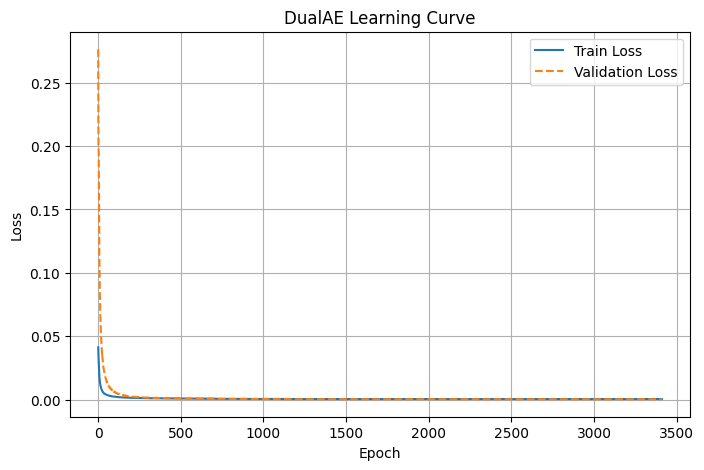

In [40]:
plot_learning_curve(m2_train_losses, m2_val_losses, model_name="DualAE")

Collected 4218 Smith-Waterman scores.


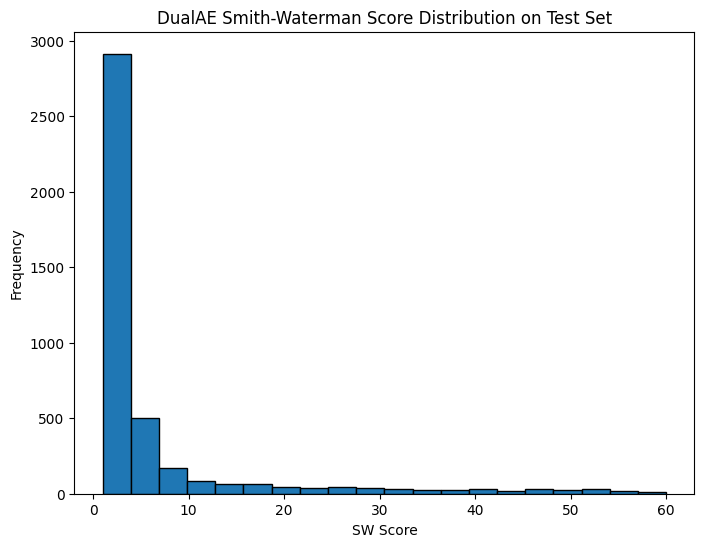

In [24]:
plot_sw_distribution(sw_scores2, model_name="DualAE")

## Model 3 - ProteinCNNLSTM Model and Training

**Model Design:**  
- **Input:** A distance matrix of shape `(B, 1, max_len, max_len)`.  
- **Architecture:**  
    - **Encoder:**
        - Uses a series of 2D residual blocks (implemented by `ResidualBlock2d`) with max pooling to extract features from the input.
        - The output from encoder is flattened and projected into a latent space via a fully connected layer.
        - The encoder produces a latent vector of size `latent_dim`.
    
    - **Decoder:**
        - A fully connected network projects the latent vector back to a sequence representation as the input of decoder.
        - A 2-layer LSTM decoder and a final linear layer produces logits over amino acid classes from sequence representation. 
- **Output:** Sequence types logits tensor of shape `(B, max_len, num_aa)`.


![Model 3](./images/CNNLSTM.png)

In [19]:
class ProteinCNNLSTM(nn.Module):
    def __init__(self, max_len=64,num_aa=20, latent_dim=128,  dropout_rate=0.3):
        super(ProteinCNNLSTM, self).__init__()
        self.max_len = max_len
        self.num_aa = num_aa
        self.latent_dim = latent_dim

        # encoder: series of ResidualBlock2d with max pooling
        self.encoder = nn.Sequential(
            ResidualBlock2d(1, 32, kernel_size=3, stride=1, padding=1, dropout_rate=dropout_rate),
            nn.MaxPool2d(2),
            ResidualBlock2d(32, 64, kernel_size=3, stride=1, padding=1, dropout_rate=dropout_rate),
            nn.MaxPool2d(2),
            ResidualBlock2d(64, 128, kernel_size=3, stride=1, padding=1, dropout_rate=dropout_rate),
            nn.MaxPool2d(2),
            nn.Flatten(),
        )
        
        # project flattened features to latent space
        self.fc_latent = nn.Linear(128 * 8 * 8, latent_dim)

        # decoder: project latent features to sequence representation
        self.fc_decode = nn.Sequential(
            nn.Linear(latent_dim, max_len * 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        # LSTM decoder: 4 layers
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=4, batch_first=True, dropout=dropout_rate)
        # final classifier: maps LSTM output to amino acid logits
        self.classifier = nn.Linear(256, num_aa)

    def encode(self, x):
        # Encode input with CNN blocks and flatten
        x = self.encoder(x)
        latent = self.fc_latent(x)
        return latent

    def decode(self, h):
        B = h.size(0)
        # Project latent vector and reshape to sequence format
        h = self.fc_decode(h)  
        h = h.view(B, self.max_len, 256)
        lstm_out, _ = self.lstm(h)
        logits = self.classifier(lstm_out)
        return logits

    def forward(self, dist_input):
        # encode then decode
        latent = self.encode(dist_input)
        logits = self.decode(latent)
        return logits


**Training and Evaluation:**  
- Uses cross-entropy loss with label smoothing.  
- Uses an AdamW optimizer and a cosine annealing warm restart scheduler.  
- Gradient clipping and early stopping are applied based on validation loss.
- After training, the model is evaluated using the Smith-Waterman algorithm, and the learning curve is plotted.
- Finally, GPU memory is cleared for the next model training.

In [21]:

def train_protein_cnnlstm(model, train_loader, val_loader, num_epochs=10000, lr=1e-3, weight_decay=1e-4, grad_clip=1.0, patience=500):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2, eta_min=1e-6)
    best_val_loss = float("inf")
    early_stop_counter = 0
    best_model_state = None
    train_losses = []
    val_losses = []
    

    for epoch in range(1, num_epochs+1):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            dist_input = batch["dist_input"]
            seq_target = batch["seq_target"]
            
            logits = model(dist_input)
            
            loss = criterion(logits.view(-1, logits.size(-1)), seq_target.view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            train_loss += loss.item() * dist_input.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                dist_input = batch["dist_input"]
                seq_target = batch["seq_target"]
                logits = model(dist_input)
                loss = criterion(logits.view(-1, logits.size(-1)), seq_target.view(-1))
                val_loss += loss.item() * dist_input.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        scheduler.step()
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch {epoch}: LR = {current_lr:.2e}, Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            early_stop_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            },'best_model_cnnlstm.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"Model 3 Training complete. Best Val Loss: {best_val_loss:.6f}")
    return model, train_losses, val_losses


In [23]:
batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# Initialize and train the model
model3 = ProteinCNNLSTM(max_len=max_len, num_aa=num_aa, latent_dim=256,  dropout_rate=0.3).to(device)
model3, m3_train_losses, m3_val_losses = train_protein_cnnlstm(
    model3,
    train_loader,
    val_loader,
    num_epochs=10000,
    lr=1e-3,
    weight_decay=1e-4,
    patience=200
)

Epoch 1: LR = 9.99e-04, Train Loss = 2.907033, Val Loss = 2.919027
Epoch 2: LR = 9.96e-04, Train Loss = 2.888998, Val Loss = 2.886007
Epoch 3: LR = 9.91e-04, Train Loss = 2.852067, Val Loss = 2.852745
Epoch 4: LR = 9.84e-04, Train Loss = 2.818853, Val Loss = 2.817231
Epoch 5: LR = 9.76e-04, Train Loss = 2.794472, Val Loss = 2.801241
Epoch 6: LR = 9.65e-04, Train Loss = 2.775528, Val Loss = 2.784066
Epoch 7: LR = 9.52e-04, Train Loss = 2.758740, Val Loss = 2.764351
Epoch 8: LR = 9.38e-04, Train Loss = 2.744263, Val Loss = 2.749782
Epoch 9: LR = 9.22e-04, Train Loss = 2.726276, Val Loss = 2.734550
Epoch 10: LR = 9.05e-04, Train Loss = 2.712296, Val Loss = 2.723714
Epoch 11: LR = 8.85e-04, Train Loss = 2.701336, Val Loss = 2.710251
Epoch 12: LR = 8.65e-04, Train Loss = 2.684039, Val Loss = 2.706763
Epoch 13: LR = 8.42e-04, Train Loss = 2.671386, Val Loss = 2.685152
Epoch 14: LR = 8.19e-04, Train Loss = 2.655841, Val Loss = 2.669535
Epoch 15: LR = 7.94e-04, Train Loss = 2.641279, Val Loss 

Model 3 Average SW Score: 15.0865
{'pred_seq': 'IVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSG', 'true_seq': 'IVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSG', 'aligned_pred': 'IVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSG', 'aligned_true': 'IVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSG', 'sw_score': np.float64(64.0)}
{'pred_seq': 'MKELPEDIIVTPNGRAIEIPGKVRKEEVRRGERVYFRYVGTDEDGRIVDLVSTGDTVELLDKDG', 'true_seq': 'GAMAKPKTKLLEGGIIIEDRVTGKGPHAKKGTRVGMRYVGKLKNGKVFDKNTKGKPFVFKLGQG', 'aligned_pred': 'RYVG', 'aligned_true': 'RYVG', 'sw_score': np.float64(4.0)}
{'pred_seq': 'SRLLTLLDQLLELLALADREELAKLGIRVVVVPVDDDLPGGGGGLLDALAAAVAAGLVIISDRL', 'true_seq': 'ELFANPRNAAAGSLRQLDPKVAASRQLDLFVYGLADAEALGIASHSEALDYLQALGFKVNPERR', 'aligned_pred': 'LADREELAKLGI', 'aligned_true': 'LAD-AE-A-LGI', 'sw_score': np.float64(4.0)}
{'pred_seq': 'SSLEELLEELLKLLKSLPPPEGLLLLLLLGGGLNVTALLAAALLLALLLALRFGKISLEQLLKA', 'true_seq': 'ESAGPLLRLVAEVEESPETAA

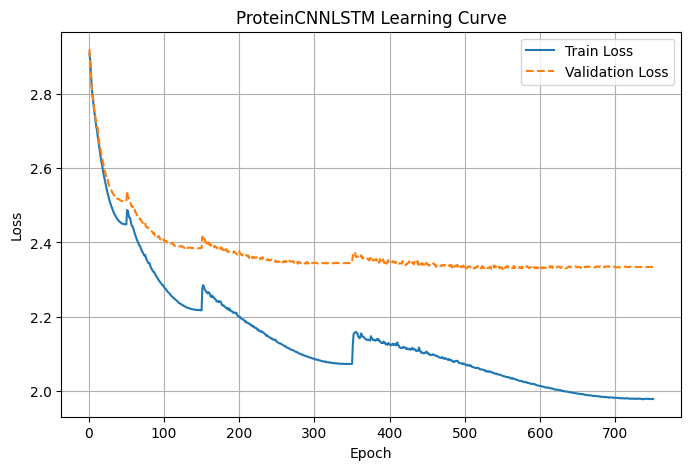

In [24]:
# Evaluate using Smith-Waterman score
avg_sw3, sw_scores3, sw_examples3 = evaluate_model_sw(model3, test_loader, idx_to_aa)
print(f"Model 3 Average SW Score: {avg_sw3:.4f}")
for ex in sw_examples3:
    print(ex)
plot_learning_curve(m3_train_losses, m3_val_losses, model_name="ProteinCNNLSTM")

Collected 4218 Smith-Waterman scores.


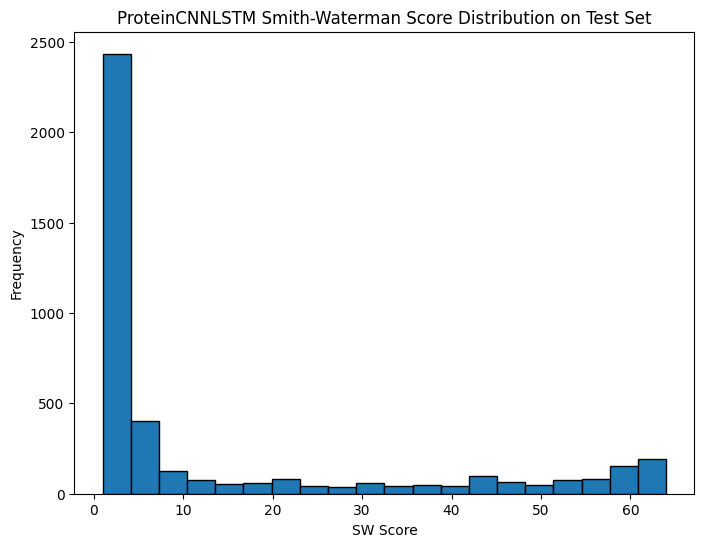

In [26]:
plot_sw_distribution(sw_scores3,model_name="ProteinCNNLSTM")

## Problems and challenges encountered in the project
Many problems and challenges have been encountered in the experiments and therefore many adjustments have been made to the model.



### Model Complexity and Single Clustering
At the beginning of the project, I assumed that there was some kind of simple linear relationship between the distance matrix and the amino acid sequence. 

Therefore, the model implementation was attempted from a simple linear model:
- **Autoencoder** uses three linear layers as encoder and decoder to extract the latent representations from amino acid sequences
- **Heteroencoder** uses CNN encoder and linear layer to transform the distance matrices into similar latent representations. 

The design idea is similar to the model 2 `CNNSequenceVAE` and `HeteroVAE`, but the internal structure of the model is much simpler. 

I also try to apply a random symmetric matrix on the sequence onehot to avoid too many `0` in the input data and can be inversed by multiply the inversed matrix.


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
             nn.Linear(latent_dim, 256),
             nn.BatchNorm1d(256),
             nn.ReLU(inplace=True),
            
             nn.Linear(256, 512),
             nn.BatchNorm1d(512),
             nn.ReLU(inplace=True),
            
             nn.Linear(512, 1024),
             nn.BatchNorm1d(1024),
             nn.ReLU(inplace=True),
            
             nn.Linear(1024, input_dim)
         )
        
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon, latent
    
class HeteroEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(HeteroEncoder, self).__init__()
        self.conv = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),  
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2), 
            nn.Dropout2d(p=0.2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.BatchNorm1d(512),
            nn.Linear(512, latent_dim) 
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        latent = self.fc(x)
        return latent
 

In [ ]:
def train_autoencoder(model, train_loader, val_loader, num_epochs=1000, lr=1e-3, weight_decay=1e-4, patience=300):
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_loss = float("inf")
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    best_model_state = None

    for epoch in range(1, num_epochs+1):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            seq_input = batch["seq_input"]
            x_recon, latent = model(seq_input)
            loss = criterion(seq_input, x_recon)
            if torch.isnan(loss):
                print("NaN loss detected, skipping batch.")
                continue
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * seq_input.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)


        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                seq_input = batch["seq_input"]
                x_recon, latent = model(seq_input)
                loss = criterion(seq_input, x_recon)
                val_loss += loss.item() * seq_input.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch {epoch}: LR = {current_lr:.2e}, Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"Model 1 Training complete. Best Val Loss: {best_val_loss:.4f}")
    return model, train_losses, val_losses

def train_heteroencoder(model,ae_model, train_loader, val_loader, num_epochs=1000, lr=1e-3, weight_decay=1e-4, patience=300):
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    ae_model.eval()
    best_val_loss = float("inf")
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    best_model_state = None

    for epoch in range(1, num_epochs+1):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            seq_input = batch["seq_input"]
            dist_input = batch["dist_input"]
            latent = model(dist_input)
            _, gt_latent = ae_model(seq_input)
            loss = criterion(latent, gt_latent)
            if torch.isnan(loss):
                print("NaN loss detected, skipping batch.")
                continue
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * seq_input.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)


        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                seq_input = batch["seq_input"]
                dist_input = batch["dist_input"]
                latent = model(dist_input)
                _, gt_latent = ae_model(seq_input)
                loss = criterion(latent, gt_latent)
                val_loss += loss.item() * seq_input.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch {epoch}: LR = {current_lr:.2e}, Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"Model 1 Training complete. Best Val Loss: {best_val_loss:.4f}")
    return model, train_losses, val_losses

**Problem**:

After evaluating it, I found that even though Autoencoder has low loss, there are some problems with its reconstructed sequences, where most of the amino acid species are labeled as majority species, which may be due to the fact that the linear model only captures local features and has difficulty understanding the structural features of the distance matrix.

The image below is the PCA cluster visualization in the latent space of autoencoder, which shows a big single cluster.

![single clustering](./images/single_clustering.png)

**Solution**:

Replace the Linear Structure into the Convolutional layers, like `CNNSequenceVAE`. It solves the single cluster problem, and also get some perfect reconstruction sequence. 

### Data Leakage
**Problem**:

After Evaluation with Smith-Waterman Algorithm, there was an unusual phenomenon, about 30% of the prediction shows a perfect match, while the other shows a 0 similarity with origin sequence.

![SW distribution](./images/false_sw_distribution.png)

After going through Dr. Paquet's assistance, I found that there were many proteins in the dataset that had similar amino acid sequences and normalized distance matrices, and some were even identical, which would lead to data leakage when constructing the training dataset versus the test dataset. Because the training and test datasets had the same data, this resulted in the test set not being able to properly evaluate the performance of the model.

**Solution**:

Proteins are checked in the data preprocessing stage to see if they have exactly similar sequences, and if so, they are filtered from the dataset.


### Challenge to Mapping two Latent Representation 
**Problem**:

When trying to map the two latent representations, I found it difficult to reduce the loss, which could be due to the lack of complexity of the network structure or due to the lack of a bottleneck layer in the model. 

**Attempts**:

I tried to solve the problem by using two autoencoders plus a mapping net. The three networks were trained in a similar way as before, using AdamW and MSELoss, respectively. However, I found that it was difficult to map their latent representations even though each of the two autoencoders performed perfectly.









In [ ]:
class SequenceAutoencoderV2(nn.Module):
    
    def __init__(self, latent_dim=256):
        super(SequenceAutoencoderV2, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.2),
        )
        

        self.fc_enc = nn.Linear(128 * 8 * 3, latent_dim)  
        
        self.latent_norm = nn.LayerNorm(latent_dim)

        self.fc_dec = nn.Linear(latent_dim, 128 * 8 * 3)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1,0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        enc = self.encoder(x)  
        B = x.size(0)
        enc_flat = enc.view(B, -1)  
        latent = self.fc_enc(enc_flat)
        latent = self.latent_norm(latent)

        dec_input = self.fc_dec(latent)  
        dec_input = dec_input.view(B, 128, 8, 3)  
        x_recon = self.decoder(dec_input)  
        return x_recon, latent
    
class DistanceAutoencoderV2(nn.Module):
    def __init__(self, latent_dim=256):
        super(DistanceAutoencoderV2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.2),
        )
        self.fc_enc = nn.Linear(128*8*8, latent_dim)
        self.latent_norm = nn.LayerNorm(latent_dim)

        self.fc_dec = nn.Linear(latent_dim, 128*8*8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   
            nn.Sigmoid()
        )

    def forward(self, x):
       
        B = x.size(0)
        enc_feat = self.encoder(x)        
        enc_flat = enc_feat.view(B, -1)    
        latent = self.fc_enc(enc_flat)
        latent = self.latent_norm(latent)

        dec_flat = self.fc_dec(latent)          
        dec_feat = dec_flat.view(B,128,8,8)
        x_recon = self.decoder(dec_feat)   
        return x_recon, latent
    
    

In [ ]:
class MappingNet(nn.Module):
    def __init__(self, in_dim=256, out_dim=256):
        super().__init__()

        self.mapping = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.2),
            nn.Linear(256, out_dim)
        )
        
        self.norm = nn.LayerNorm(out_dim)

    def forward(self, z_d):
        z = self.mapping(z_d)
        z = self.norm(z)
        return z

### Train Two Models Simultaneously
After fruitless attempts, I went back to the previous idea of Autoencoder + Heteroencoder, but took a completely new approach to training, i.e. training both networks simultaneously. It was implemented by adding parameters from two models together and pass them into the optimizer, and add their loss together with a parameter that control the weight of mapping loss (A low mapping weight means that the optimizer will work harder to optimize the performance of the autoencoder and vice versa)

However, after actual experiments, I found a drawback of training two models at the same time, that is, due to the existence of the step of calculating the MSE loss between two latent representations `loss_mapping = criterion(latent_het, latent_seq)` in the loss function `loss = loss_ae + lambda_mapping * loss_mapping`, the model may get a relatively small MSE loss by constantly decreasing the scale of latent representations. It is difficult to find a way to directly limit the latent representation scale from continuing to shrink.

In order to solve this problem, I tried many different methods, such as:
 - replacing `MSELoss` with `cosine similarity` instead,
 - using `tanh` instead of `layer norm`.

Unfortunately, none of them worked very well to gather more than 10 SW score. While `cosine similarity loss` really create many improvement in the evaluation, see `Model 2 - Two Models` for the exact implementation.




### Single Model
So I started to change my mind and tried to design a single model accepting the distance matrix as input and generating either onehot encoding of sequence or logit as output (depending on the different loss functions). This is usually demanding on the internal structure of that model, so I referred to many literatures in similar areas and tried many combinations of different model structures, and design:
- `model 1 - MultiScaleConvTransformer`, 
- `Model 3 - ProteinCNNLSTM`. 

In addition, `model 1 - MultiScaleConvTransformer` using a network structure of multidimensional residual convolution plus transformer had the best performance on this task.

## Reference
[1] Slavianap, “Smith-Waterman-Algorithm/Script.py at master · SLAVIANAP/smith-waterman-algorithm,” GitHub, https://github.com/slavianap/Smith-Waterman-Algorithm/blob/master/Script.py (accessed Apr. 7, 2025). 

[2]C.-Y. Chang, “Building a customized residual CNN with pytorch,” Medium, https://medium.com/@chen-yu/building-a-customized-residual-cnn-with-pytorch-471810e894ed (accessed Apr. 7, 2025). 

[3] Y. Dan, “Using positional encoding in pytorch,” Stack Overflow, https://stackoverflow.com/questions/77444485/using-positional-encoding-in-pytorch (accessed Apr. 7, 2025). 



